In [1]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import scipy.linalg
from ipywidgets import interact, fixed, widgets
from sympy.interactive import printing
printing.init_printing(use_latex=True)

## Problema 1
La función de costo $\textbf{J}$ es el error cuadrático promedio en una regresión lineal.

$$\textbf{J}(\beta_0, \beta_1) = \frac{1}{2m}\sum_{(x^{(i)}, y^{(i)}) \in X \times Y} (y^{(i)} - \hat{y}^{(i)}(x^{(i)}))^2 = \frac{1}{2m}\sum_{(x^{(i)}, y^{(i)}) \in X \times Y} (y^{(i)} - \beta_0 - \beta_1 x^{(i)})^2$$

(a) Usando SimPy demostrar que

$$
\frac{\partial}{\partial \beta_j} \textbf{J}(\beta) = \frac{1}{m}\sum_{i=1}^{m}\left(\hat{y}(x^{(i)}) - y(x^{(i)})\right) \cdot x^{(i)}_j
$$
Para el caso de $\beta_0, \beta_1$ en $J(\beta_0,\beta_1)$.

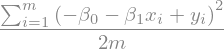

In [2]:
x = Symbol('x')
y = Symbol('y')
i = Symbol('i')
m = Symbol('m')
b0 = Symbol('beta_0')
b1 = Symbol('beta_1')

j = Function('j')
j = 1/(2*m)*Sum((Indexed(y,i) - b0 - b1 * Indexed(x,i))**2, (i, 1, m))
j

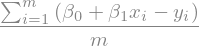

In [3]:
j_b0 = simplify(Derivative(j,b0 ).doit())
simplify(j_b0)

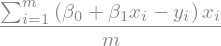

In [4]:
j_b1 = Derivative(j,b1).doit()
simplify(j_b1)

## Problema 2
Usando el ejemplo de la clase ( i.e. Los archivos edad.dat y altura.dat contienen las mediciones de las estaturas (en metros) de varios niños entre las edad de 2 y 8 años. Cada tupla de altura y edad, constituyen un ejemplo de entrenamiento $(x^{(i)}, y^{(i)})$ de nuestros datos. Hay $m = 50$ datos para entrenar que usaremos para realizar un modelo de regresión lineal. ) :

(a) Grafique $\textbf{J}(\beta)$ del ejercicio en $3D$ y en una gráfica de contorno.

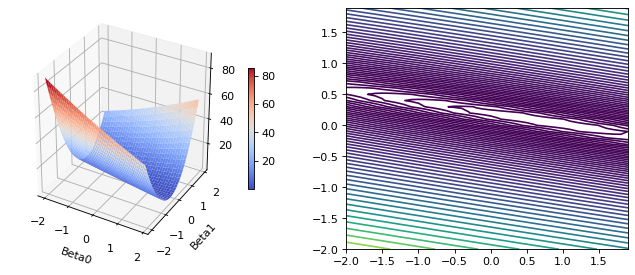

In [5]:
X = np.loadtxt('data/edad.dat')
Y = np.loadtxt('data/altura.dat')
m = len(X)

# Hacemos una malla x-y entre -2<x<2 and -2<y<2 en steps de 0.06
db0 = 0.1
db1 = 0.1
b0 = np.arange(-2, 2, db0)
b1 = np.arange(-2, 2, db1)
b0, b1 = np.meshgrid(b0, b1)

# La fucnión J(b0,b1)
def J(b_0, b_1):
    costo = 0
    for i in range(0,m):
        costo += (Y[i] - b_0 - b_1*X[i])**2
    return costo/(2*m)

fig = plt.figure(figsize=plt.figaspect(0.4), dpi=80)

ax = fig.add_subplot(1, 2, 1, projection='3d')
p = ax.plot_surface(b0, b1, J(b0,b1), rstride=1, cstride=1, linewidth=0,cmap=cm.coolwarm)
cb = fig.colorbar(p, shrink=.5)
plt.xlabel("Beta0")
plt.ylabel("Beta1")

ax = fig.add_subplot(1, 2, 2)
levels = np.logspace(0,2,50)-1
plt.contour(b0,b1,J(b0,b1),levels);

(b) Indique con un punto el valor de $\textbf{J}(\beta)$ en la última iteración.

In [6]:
class RegresionLineal:
    def __init__(self, alpha=0.3, max_iters=100, tols=0.001):
        """
        Parámetros.
        ---------------
        alpha = Learning rate
        max_iters = Número máximo de iteraciones
        tols = definición de convergencia
        """
        self.alpha = alpha
        self.max_iters = max_iters
        self.tols = tols
        self.breaking_iteration = None
        self.historia = {'costo':[], 'beta':[]}  # Con fines de graficación
        
    def gradientDescent(self, x, y):
        """
        Parámetros:
        ---------------
        x = vector de entrenamiento de features
        y = vector de entrenamiento de variable a predecir (target)
        """    
        
        # ajustamos el vector de features
        unos = np.ones((x.shape[0], 1))
        Xt = x.reshape(x.shape[0], 1)
        Xt = np.concatenate((unos, Xt), axis=1)
        
        i = 0
        prep_J = 0
        m, n = Xt.shape
        self.beta = np.zeros(n) 
        
        while i < self.max_iters:     
            # Actualizamos beta
            self.beta = self.beta - self.alpha * self.gradiente(Xt, y)
            
            J = self.costo(Xt, y)
            
            if abs(J - prep_J) <= self.tols:
                print('La función convergió con beta: %s en la iteración %i' % ( str(self.beta), i ))
                self.breaking_iteration = i
                break
            else:
                prep_J = J
            
            self.historia['costo'].append(J)
            self.historia['beta'].append(self.beta)                
            i += 1
    
    def hipotesis(self, x):
        return np.dot(x, self.beta)
    
    def costo(self, x, y):
        m = x.shape[0]
        error = self.hipotesis(x) - y
        return np.dot(error.T, error) / (2 * m) 
    
    def gradiente(self, x, y):
        m = x.shape[0]
        error = self.hipotesis(x) - y        
        return np.dot(x.T, error) / m

La función convergió con beta: [0.73300235 0.06700325] en la iteración 1190


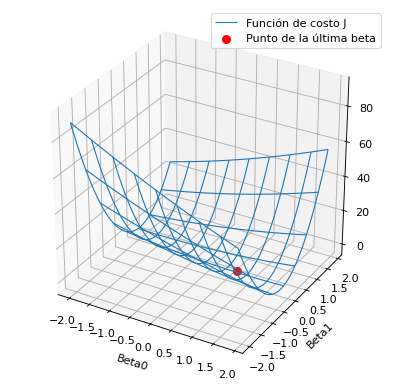

In [7]:
r = RegresionLineal(alpha=0.03, max_iters=10000, tols=0.0000001)
r.gradientDescent(X, Y)
beta_ = r.beta
#J(beta_[0],beta_[1])

#%matplotlib notebook
fig = plt.figure(figsize=(6.1, 6.1), dpi=80)
ax = fig.gca(projection='3d')
ax.plot_wireframe(b0, b1, J(b0,b1), rstride=5, cstride=5, linewidth=1,label='Función de costo J')
plt.xlabel("Beta0")
plt.ylabel("Beta1")
ax.scatter(beta_[0], beta_[1], J(beta_[0],beta_[1]),s=50, c="r",label='Punto de la última beta')
ax.legend(loc='best')
ax.view_init(30, -60) # Posición de la cámara (elevación, rotación eje z)

(c) Modifique el widget para mostrar conforme pasan las iteraciones como el valor de $\textbf{J}(\beta)$ se acerca al mínimo en la gráfica de contorno.

In [9]:
def plotModelo(x,y,rl,iteracion):
    beta_ = r.historia['beta'][iteracion]
    fig = plt.figure()
    plt.contour(b0,b1,J(b0,b1),levels= np.logspace(0,2,50)-1)
    plt.scatter(beta_[0], beta_[1], s=100, c = "red")

u_iter = (r.breaking_iteration - 1) if r.breaking_iteration else (r.max_iters - 1)
interact(plotModelo, x=fixed(X), y=fixed(Y), rl=fixed(r), iteracion=(0,u_iter,100));

interactive(children=(IntSlider(value=500, description='iteracion', max=1189, step=100), Output()), _dom_class…

(d) Agrega al widget un control para modificar $\alpha$ (habrá que agregar el entrenamiento del modelo a la función que estás realizando para este widget)

In [10]:
def plotOtroModelo(x,y,alpha,iteracion):
    modelo = lambda x,b,m: b + m*x # función para graficar el modelo
    r = RegresionLineal(alpha, max_iters=10000, tols=0.0000001)
    r.gradientDescent(x,y)
    _beta = r.historia['beta'][iteracion]
    

    fig, ax = plt.subplots(1,2, figsize=(10,6))
    ax[0].scatter(x,y, label="datos")
    ax[0].plot(x, modelo(x, _beta[0], _beta[1]), label="int: %1.2f, pen: %1.2f" % (_beta[0], _beta[1]))
    ax[0].set_xlabel('Edad (yr)')
    ax[0].set_ylabel('Altura (m)')
    ax[0].legend(loc="best")
    #ax[0].set_xlim(0, max(x))
    #ax[0].set_ylim(0, max(y))
    
    costo  = r.historia['costo']
    
    iteraciones = [i for i in range(0, len(costo))]
    ax[1].plot(iteraciones, costo, 'g', label="costo")
    ax[1].plot(iteracion, costo[iteracion], 'or', label="iteracion")
    ax[1].set_xlabel('Iteraciones')
    ax[1].set_ylabel('Costo')
    ax[1].legend(loc="best")
    
interact(plotOtroModelo, x=fixed(X), y=fixed(Y), alpha=(0,.05,.005), iteracion=(0,1000,50));

interactive(children=(FloatSlider(value=0.025, description='alpha', max=0.05, step=0.005), IntSlider(value=500…

## Problema 3
(a) Usando los datos de chirps.txt

In [11]:
%cat data/chirps.txt

#Chirps/Second 	Temperature (º F)
20.0 	88.6
16.0 	71.6
19.8 	93.3
18.4 	84.3
17.1 	80.6
15.5 	75.2
14.7 	69.7
15.7 	71.6
15.4 	69.4
16.3 	83.3
15.0 	79.6
17.2 	82.6
16.0 	80.6
17.0 	83.5
14.4 	76.3


Entrenar una regresión lineal. Grafique los datos y el mejor modelo. Explique como llegó a los valores de $\alpha$. ¿Coinciden con los mostrados en la página web?

La función convergió con beta: [22.84857013  3.41034763] en la iteración 158339
la diferencia entre las betas son d1 = -2.4634607218132487e-05 y d2 = 0.00041218050169433695


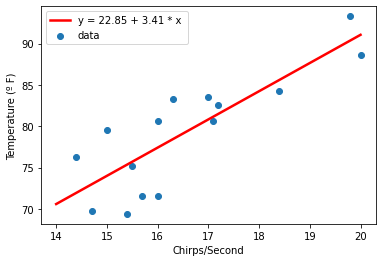

In [12]:
DataIn = np.loadtxt('data/chirps.txt')
X = DataIn[:,0]
Y = DataIn[:,1]

# Encontré los parámetros al tanteo hasta que me pareció suficiente parecido
r = RegresionLineal(alpha=0.007, max_iters=1000000, tols=0.0000000000001)
r.gradientDescent(X, Y)
beta = r.beta

plt.scatter(X,Y, label="data")
plt.xlabel('Chirps/Second')
plt.ylabel('Temperature (º F)')
plt.plot([14, 20], [beta[0]+14*beta[1],beta[0]+20*beta[1] ], label="y = %1.2f + %1.2f * x " % (beta[0],beta[1]), color='red', linewidth=2.5, linestyle="-")
plt.legend(loc = "best")
print("la diferencia entre las betas son d1 = %s y d2 = %s" % (3.410323-beta[1],22.84898231-beta[0]))

## Problema 4
(a) Usando los datos del cuarteto de Anscombe Calcule la regresión lineal ¿Qué sucede?

La función convergió con beta: [2.99720326 0.50037684] en la iteración 6354
La función convergió con beta: [2.99802063 0.50028601] en la iteración 6354
La función convergió con beta: [2.99956769 0.50001313] en la iteración 6355
La función convergió con beta: [2.99883801 0.50019518] en la iteración 6354


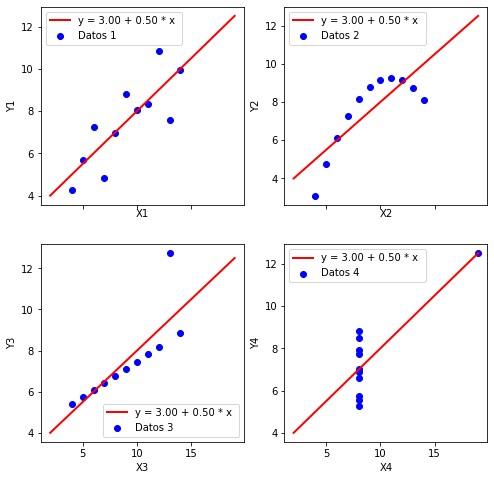

In [13]:
DataIn = np.loadtxt('data/AnscombesQuartet.txt')
X1 = DataIn[:,0]
Y1 = DataIn[:,1]
X2 = DataIn[:,2]
Y2 = DataIn[:,3]
X3 = DataIn[:,4]
Y3 = DataIn[:,5]
X4 = DataIn[:,6]
Y4 = DataIn[:,7]

r1 = RegresionLineal(alpha=0.01, max_iters=100000, tols=0.000000001)
r1.gradientDescent(X1, Y1)
r2 = RegresionLineal(alpha=0.01, max_iters=100000, tols=0.000000001)
r2.gradientDescent(X2, Y2)
r3 = RegresionLineal(alpha=0.01, max_iters=100000, tols=0.000000001)
r3.gradientDescent(X3, Y3)
r4 = RegresionLineal(alpha=0.01, max_iters=100000, tols=0.000000001)
r4.gradientDescent(X4, Y4)

fig, ax = plt.subplots(2,2, figsize=(8,8), sharex = True)

ax[0][0].scatter(X1, Y1, label="Datos 1", c='b')
ax[0][0].plot([2, 19], [r1.beta[0]+2*r1.beta[1],r1.beta[0]+19*r1.beta[1]],label="y = %1.2f + %1.2f * x " % (r1.beta[0],r1.beta[1]), c='r', linewidth=2, linestyle="-")
ax[0][0].set_xlabel("X1")
ax[0][0].set_ylabel("Y1")
ax[0][0].legend(loc = "best")

ax[0][1].scatter(X2, Y2, label="Datos 2", c='b')
ax[0][1].plot([2,19], [r2.beta[0]+2*r2.beta[1],r2.beta[0]+19*r2.beta[1]],label="y = %1.2f + %1.2f * x " % (r2.beta[0],r2.beta[1]), c='r', linewidth=2, linestyle="-")
ax[0][1].set_xlabel("X2")
ax[0][1].set_ylabel("Y2")
ax[0][1].legend(loc = "best")

ax[1][0].scatter(X3, Y3, label="Datos 3", c='b')
ax[1][0].plot([2,19], [r3.beta[0]+2*r3.beta[1],r3.beta[0]+19*r3.beta[1]], label="y = %1.2f + %1.2f * x " % (r3.beta[0],r3.beta[1]), c='r', linewidth=2, linestyle="-")
ax[1][0].set_xlabel("X3")
ax[1][0].set_ylabel("Y3")
ax[1][0].legend(loc = "best")

ax[1][1].scatter(X4, Y4, label="Datos 4", c='b')
ax[1][1].plot([2, 19], [r4.beta[0]+2*r4.beta[1],r4.beta[0]+19*r4.beta[1]], label="y = %1.2f + %1.2f * x " % (r4.beta[0],r4.beta[1]), c='r', linewidth=2, linestyle="-")
ax[1][1].set_xlabel("X4")
ax[1][1].set_ylabel("Y4")
ax[1][1].legend(loc = "best")

## Problema 5
Use el archivo radioactive_decay.dat

In [14]:
%cat data/radioactive_decay.txt

#time   N_(remaining)
0.0	10.48
1.0	7.54
2.0	5.49
3.0	4.02
4.0	2.74
5.0	2.02
6.0	1.50
7.0	1.09
8.0	0.68
9.0	0.57
10.0	0.37
11.0	0.31
12.0	0.19
13.0	0.15
14.0	0.13
15.0	0.11


(a) Grafique los datos ¿Qué forma tienen?

La función convergió con beta: [ 6.43389043 -0.54710253] en la iteración 826


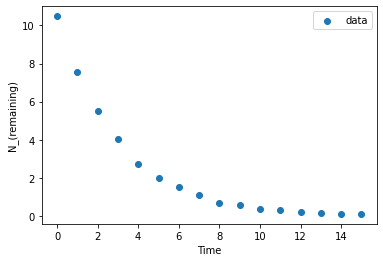

In [15]:
DataIn = np.loadtxt('data/radioactive_decay.txt')
X = DataIn[:,0]
Y = DataIn[:,1]

plt.scatter(X,Y, label="data")
plt.xlabel('Time')
plt.ylabel('N_(remaining)')
plt.legend(loc='best')

r = RegresionLineal(alpha=0.025, max_iters=100000, tols=0.000001)
r.gradientDescent(X, Y)

# Tienen forma de una exponencial

(b) ¿Qué transformación se le ocurre para linearizarlos? Explique y grafique de nuevo. Guarde los datos transformados en un archivo llamado transform_radioactive_decay.txt

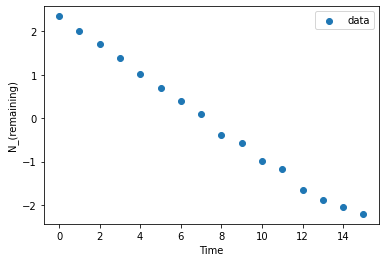

In [16]:
# Ponemos aplicarle el logaritmo a los datos para linearizarlos
txt = np.savetxt('data/transform_radioactive_decay.txt', np.stack((X, np.log(Y)), axis=1))

plt.scatter(X,np.log(Y), label="data")
plt.xlabel('Time')
plt.ylabel('N_(remaining)')
plt.legend(loc='best')

(c) Aplique la regresión lineal a este conjunto de datos transformado, leyendo los datos del archivo recién creado.

La función convergió con beta: [ 2.27358676 -0.31441199] en la iteración 675


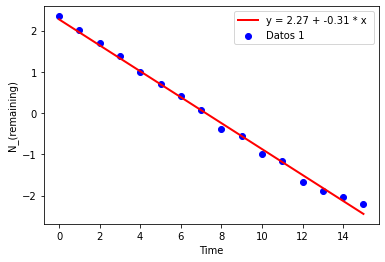

In [17]:
DataIn = np.loadtxt('data/transform_radioactive_decay.txt')
X = DataIn[:,0]
Y = DataIn[:,1]

r1 = RegresionLineal(alpha=0.025, max_iters=100000, tols=0.000001)
r1.gradientDescent(X, Y)

plt.scatter(X, Y, label="Datos 1", c='b')
plt.plot([X[0], X[-1]], [r1.beta[0]+X[0]*r1.beta[1],r1.beta[0]+X[-1]*r1.beta[1]],label="y = %1.2f + %1.2f * x " % (r1.beta[0],r1.beta[1]), c='r', linewidth=2, linestyle="-")
plt.xlabel('Time')
plt.ylabel('N_(remaining)')
plt.legend(loc='best')

(d) ¿Cuáles son los valores de $\beta$ que mejor ajustan? ¿Cuáles son el espacio sin transformar? Explique.

In [18]:
print("Las betas que mejor se ajustaron bajo la transormación son b0 = %s y b1 = %s" % (r1.beta[0],r1.beta[1]))

print("Las betas que mejor se ajustaron en el espacio sin transformar son b0 = %s y b1 = %s" % (r.beta[0],r.beta[1]))

print("Hacer la regresión lineal sin transformar el espacio es posible, sin embargo, como los datos no siguen una trayectoria lineal, la distancia de los datos a la recta será mayor.")
print("Si le aplicamos la funcion exponencial a la regresión bajo la transformación, nos regresará un menor costo que simplemente hacer la regresión sin modificar los datos")

Las betas que mejor se ajustaron bajo la transormación son b0 = 2.273586762076716 y b1 = -0.3144119908570582
Las betas que mejor se ajustaron en el espacio sin transformar son b0 = 6.433890430174945 y b1 = -0.5471025279663054
Hacer la regresión lineal sin transformar el espacio es posible, sin embargo, como los datos no siguen una trayectoria lineal, la distancia de los datos a la recta será mayor.
Si le aplicamos la funcion exponencial a la regresión bajo la transformación, nos regresará un menor costo que simplemente hacer la regresión sin modificar los datos
